In [1]:
!pip install remotezip tqdm opencv-python > info.txt
!pip install -q git+https://github.com/tensorflow/docs > info.txt

In [2]:
import tqdm
import random
import pathlib
import itertools
import collections
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
import einops


# Some modules to display an animation using imageio.
import imageio
from IPython import display
from urllib import request
from tensorflow_docs.vis import embed
import kagglehub

# Download latest version
path = kagglehub.dataset_download("pevogam/ucf101")

print("Path to dataset files:", path)

2025-05-18 04:26:53.144946: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747542413.327504      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747542413.380283      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Path to dataset files: /kaggle/input/ucf101


In [3]:
import os
import shutil
import random
import pathlib
from collections import defaultdict


def split_ucf_101_subset(dataset_path, class_label_list, splits, output_dir):
    """Create a subset of the UCF101 dataset and split into train, validation, and test sets.
    
    Args:
        dataset_path: Path to the UCF101 dataset (e.g., '/kaggle/input/ucf101')
        class_label_list: list of labels of classes to include in the data
        splits: Dictionary with splits (e.g., {"train": 70, "val": 15, "test": 15})
                Values represent percentages
        output_dir: Directory to save the split datasets
        
    Returns:
        Dictionary mapping split names to their respective directories
    """
    # Ensure output directory exists
    output_dir = pathlib.Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Validate splits percentages
    total_percentage = sum(splits.values())
    if total_percentage != 100:
        raise ValueError(f"Split percentages must sum to 100, got {total_percentage}")
    
    # Find all video files in the dataset
    ucf_dir = os.path.join(dataset_path, "UCF101", "UCF-101")
    if not os.path.exists(ucf_dir):
        raise FileNotFoundError(f"UCF-101 directory not found at {ucf_dir}")
    
    # Get selected classes (directories)
    selected_classes = sorted([d for d in os.listdir(ucf_dir) 
                          if os.path.isdir(os.path.join(ucf_dir, d)) and d in class_label_list])
    
    # # Select subset of classes
    # if num_classes > len(all_classes):
    #     print(f"Warning: Requested {num_classes} classes but only {len(all_classes)} are available.")
    #     selected_classes = all_classes
    # else:
    #     selected_classes = all_classes[:num_classes]
    
    # Collect files for each class
    files_for_class = defaultdict(list)
    for cls in selected_classes:
        class_dir = os.path.join(ucf_dir, cls)
        for video_file in os.listdir(class_dir):
            if video_file.endswith(".avi"):  # UCF-101 videos are in .avi format
                files_for_class[cls].append(os.path.join(class_dir, video_file))
    
    # Shuffle files for each class
    for cls in files_for_class:
        random.shuffle(files_for_class[cls])
    
    # Create output directories for each split
    split_dirs = {}
    for split_name in splits.keys():
        split_dir = output_dir / split_name
        split_dir.mkdir(exist_ok=True)
        split_dirs[split_name] = split_dir
        
        # Create class subdirectories in each split
        for cls in selected_classes:
            os.makedirs(os.path.join(split_dir, cls), exist_ok=True)
    
    # Split files according to percentages and copy to destination
    for cls, files in files_for_class.items():
        total_files = len(files)
        start_idx = 0
        
        for split_name, percentage in splits.items():
            # Calculate number of files for this split
            split_count = int(total_files * percentage / 100)
            
            # Get files for this split
            if split_name == list(splits.keys())[-1]:  # For the last split, take all remaining files
                split_files = files[start_idx:]
            else:
                split_files = files[start_idx:start_idx + split_count]
                start_idx += split_count
            
            # Copy files to destination
            for file in split_files:
                dest_dir = os.path.join(split_dirs[split_name], cls)
                dest_file = os.path.join(dest_dir, os.path.basename(file))
                shutil.copy2(file, dest_file)
            
            print(f"{split_name}: Copied {len(split_files)} files for class {cls}")
    
    return split_dirs


# Example usage:
if __name__ == "__main__":
    DATASET_PATH = "/kaggle/input/ucf101"
    CLASS_LABELS = sorted(['ApplyEyeMakeup', 
                    'PlayingDhol', 
                    'BabyCrawling', 
                    'Haircut', 
                    'SkyDiving',
                   'Surfing', 
                    'Rafting', 
                    'CricketShot', 
                    'ShavingBeard'])
    
    output_dir = pathlib.Path('./UCF101_subset/')
    subset_paths = split_ucf_101_subset(
        dataset_path=DATASET_PATH,
        class_label_list=CLASS_LABELS,
        splits={"train": 70, "val": 15, "test": 15},
        output_dir=output_dir
    )
    
    print("Dataset splits created at:")
    for split_name, split_dir in subset_paths.items():
        print(f"  {split_name}: {split_dir}")

train: Copied 101 files for class ApplyEyeMakeup
val: Copied 21 files for class ApplyEyeMakeup
test: Copied 23 files for class ApplyEyeMakeup
train: Copied 92 files for class BabyCrawling
val: Copied 19 files for class BabyCrawling
test: Copied 21 files for class BabyCrawling
train: Copied 116 files for class CricketShot
val: Copied 25 files for class CricketShot
test: Copied 26 files for class CricketShot
train: Copied 91 files for class Haircut
val: Copied 19 files for class Haircut
test: Copied 20 files for class Haircut
train: Copied 114 files for class PlayingDhol
val: Copied 24 files for class PlayingDhol
test: Copied 26 files for class PlayingDhol
train: Copied 77 files for class Rafting
val: Copied 16 files for class Rafting
test: Copied 18 files for class Rafting
train: Copied 112 files for class ShavingBeard
val: Copied 24 files for class ShavingBeard
test: Copied 25 files for class ShavingBeard
train: Copied 77 files for class SkyDiving
val: Copied 16 files for class SkyDivi

In [ ]:
def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.
    
    Args:
      frame: Image that needs to resized and padded. 
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame



def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))  

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

In [5]:
class FrameGenerator:
  def __init__(self, path, n_frames, training = False):
    """ Returns a set of frames with their associated label. 

      Args:
        path: Video file paths.
        n_frames: Number of frames. 
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.avi'))
    classes = [p.parent.name for p in video_paths] 
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames) 
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

In [6]:
# Create the training set

def get_train_val_test(n_frames=10, batch_size=2):
    output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

    train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], 10, training=True),
                                          output_signature = output_signature)
    val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], 10),
                                        output_signature = output_signature)
    test_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['test'], 10),
                                         output_signature = output_signature)

    AUTOTUNE = tf.data.AUTOTUNE
    
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
    val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

    train_ds = train_ds.batch(2)
    val_ds = val_ds.batch(2)
    test_ds = test_ds.batch(2)

    return train_ds, val_ds, test_ds

In [7]:
# callbacks to control the learning rate & early stopping
reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',    # or 'loss' if no validation set
    factor=0.5,            # reduce LR by a factor of 0.5
    patience=2,            # wait 2 epochs with no improvement
    verbose=1,             # print updates
    min_lr=1.25e-5            # never go below this
)

def scheduler(epoch, lr):
    if epoch % 5 == 0 and epoch > 0:
        return lr * 0.5
    return lr

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)


initial_lr = 1e-3
exp_decay = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_lr,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True
)

# optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

early_stopping = tf.keras.callbacks.EarlyStopping(patience = 5, monitor = 'val_loss')

In [8]:
def plot_history(history):
  """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
  """
  fig, (ax1, ax2) = plt.subplots(2)

  fig.set_size_inches(18.5, 10.5)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history.history['loss'], label = 'train')
  ax1.plot(history.history['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')

  # Determine upper bound of y-axis
  max_loss = max(history.history['loss'] + history.history['val_loss'])

  ax1.set_ylim([0, np.ceil(max_loss)])
  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation']) 

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history.history['accuracy'],  label = 'train')
  ax2.plot(history.history['val_accuracy'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_ylim([0, 1])
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'])

  plt.show()


def get_actual_predicted_labels(model, dataset): 
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted


def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

In [9]:
# Define the dimensions of one frame in the set of frames created
HEIGHT = 224
WIDTH = 224

class Conv2Plus1D(tf.keras.layers.Layer):
  def __init__(self, filters, kernel_size, padding):
    """
      A sequence of convolutional layers that first apply the convolution operation over the
      spatial dimensions, and then the temporal dimension. 
    """
    super().__init__()
    self.seq = tf.keras.Sequential([  
        # Spatial decomposition
        layers.Conv3D(filters=filters,
                      kernel_size=(1, kernel_size[1], kernel_size[2]),
                      padding=padding),
        # Temporal decomposition
        layers.Conv3D(filters=filters, 
                      kernel_size=(kernel_size[0], 1, 1),
                      padding=padding)
        ])
  
  def call(self, x):
    return self.seq(x)


class ResidualMain(tf.keras.layers.Layer):
  """
    Residual block of the model with convolution, layer normalization, and the
    activation function, ReLU.
  """
  def __init__(self, filters, kernel_size):
    super().__init__()
    self.seq = tf.keras.Sequential([
        Conv2Plus1D(filters=filters,
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization(),
        layers.ReLU(),
        Conv2Plus1D(filters=filters, 
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization()
    ])
    
  def call(self, x):
    return self.seq(x)

class Project(keras.layers.Layer):
  """
    Project certain dimensions of the tensor as the data is passed through different 
    sized filters and downsampled. 
  """
  def __init__(self, units):
    super().__init__()
    self.seq = keras.Sequential([
        layers.Dense(units),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)


def add_residual_block(input, filters, kernel_size):
  """
    Add residual blocks to the model. If the last dimensions of the input data
    and filter size does not match, project it such that last dimension matches.
  """
  out = ResidualMain(filters, 
                     kernel_size)(input)
  
  res = input
  # Using the Keras functional APIs, project the last dimension of the tensor to
  # match the new filter size
  if out.shape[-1] != input.shape[-1]:
    res = Project(out.shape[-1])(res)

  return layers.add([res, out])


class ResizeVideo(keras.layers.Layer):
  def __init__(self, height, width):
    super().__init__()
    self.height = height
    self.width = width
    self.resizing_layer = layers.Resizing(self.height, self.width)

  def call(self, video):
    """
      Use the einops library to resize the tensor.  
      
      Args:
        video: Tensor representation of the video, in the form of a set of frames.
      
      Return:
        A downsampled size of the video according to the new height and width it should be resized to.
    """
    # b stands for batch size, t stands for time, h stands for height, 
    # w stands for width, and c stands for the number of channels.
    old_shape = einops.parse_shape(video, 'b t h w c')
    images = einops.rearrange(video, 'b t h w c -> (b t) h w c')
    images = self.resizing_layer(images)
    videos = einops.rearrange(
        images, '(b t) h w c -> b t h w c',
        t = old_shape['t'])
    return videos



In [10]:
input_shape = (None, 10, HEIGHT, WIDTH, 3)
input = layers.Input(shape=(input_shape[1:]))
x = input

x = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = ResizeVideo(HEIGHT // 2, WIDTH // 2)(x)

# Block 1
x = add_residual_block(x, 16, (3, 3, 3))
x = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x)

# Block 2
x = add_residual_block(x, 32, (3, 3, 3))
x = ResizeVideo(HEIGHT // 8, WIDTH // 8)(x)

# Block 3
x = add_residual_block(x, 64, (3, 3, 3))
x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x)

# Block 4
x = add_residual_block(x, 128, (3, 3, 3))

x = layers.GlobalAveragePooling3D()(x)
x = layers.Flatten()(x)
x = layers.Dense(9)(x)

model = keras.Model(input, x)

I0000 00:00:1747542442.709781      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [11]:
model.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 10, 224, 224,   │              0 │ -                      │
│                           │ 3)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_plus1d              │ (None, 10, 224, 224,   │          3,152 │ input_layer[0][0]      │
│ (Conv2Plus1D)             │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 10, 224, 224,   │             64 │ conv2_plus1d[0][0]     │
│ (BatchNormalization)      │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 10, 224, 224,   │              0 │ batch_normalization[0… │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resize_video              │ (None, 10, 112, 112,   │              0 │ re_lu[0][0]            │
│ (ResizeVideo)             │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ residual_main             │ (None, 10, 112, 112,   │          6,272 │ resize_video[0][0]     │
│ (ResidualMain)            │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 10, 112, 112,   │              0 │ resize_video[0][0],    │
│                           │ 16)                    │                │ residual_main[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resize_video_1            │ (None, 10, 56, 56, 16) │              0 │ add[0][0]              │
│ (ResizeVideo)             │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ project (Project)         │ (None, 10, 56, 56, 32) │            608 │ resize_video_1[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ residual_main_1           │ (None, 10, 56, 56, 32) │         20,224 │ resize_video_1[0][0]   │
│ (ResidualMain)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 10, 56, 56, 32) │              0 │ project[0][0],         │
│                           │                        │                │ residual_main_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resize_video_2            │ (None, 10, 28, 28, 32) │              0 │ add_1[0][0]            │
│ (ResizeVideo)             │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ project_1 (Project)       │ (None, 10, 28, 28, 64) │          2,240 │ resize_video_2[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ residual_main_2           │ (None, 10, 28, 28, 64) │         80,384 │ resize_video_2[0][0]   │
│ (ResidualMain)       

 Total params: 443,193 (1.69 MB)

 Trainable params: 443,161 (1.69 MB)

 Non-trainable params: 32 (128.00 B)

In [12]:
model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer = keras.optimizers.Adam(learning_rate = 0.001), 
              metrics = ['accuracy'])

train_ds, val_ds, test_ds = get_train_val_test()

In [ ]:
history = model.fit(x = train_ds,
                    epochs = 50, 
                    validation_data = val_ds,
                   callbacks=[reduce_lr_on_plateau, early_stopping])

Epoch 1/50


I0000 00:00:1747542549.275039     140 service.cc:148] XLA service 0x7f24a40c1100 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747542549.275901     140 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1747542550.786802     140 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1747542551.928513     140 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1747542552.119512     140 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


      2/Unknown 109s 82ms/step - accuracy: 0.0000e+00 - loss: 4.7441

I0000 00:00:1747542561.859621     140 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


    434/Unknown 140s 72ms/step - accuracy: 0.1119 - loss: 2.9584

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


434/434 ━━━━━━━━━━━━━━━━━━━━ 163s 124ms/step - accuracy: 0.1119 - loss: 2.9575 - val_accuracy: 0.1154 - val_loss: 2.3773 - learning_rate: 0.0010
Epoch 2/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 34s 77ms/step - accuracy: 0.1206 - loss: 2.3197 - val_accuracy: 0.1209 - val_loss: 2.4201 - learning_rate: 0.0010
Epoch 3/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 34s 77ms/step - accuracy: 0.1878 - loss: 2.1866 - val_accuracy: 0.2088 - val_loss: 2.0079 - learning_rate: 0.0010
Epoch 4/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 34s 77ms/step - accuracy: 0.2366 - loss: 2.0199 - val_accuracy: 0.2802 - val_loss: 1.8446 - learning_rate: 0.0010
Epoch 5/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 34s 77ms/step - accuracy: 0.3086 - loss: 1.8130 - val_accuracy: 0.3681 - val_loss: 1.6617 - learning_rate: 0.0010
Epoch 6/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 34s 77ms/step - accuracy: 0.3901 - loss: 1.6166 - val_accuracy: 0.4121 - val_loss: 1.5327 - learning_rate: 0.0010
Epoch 7/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 34s 77ms/step - accuracy: 0.3770 - loss: 1.63

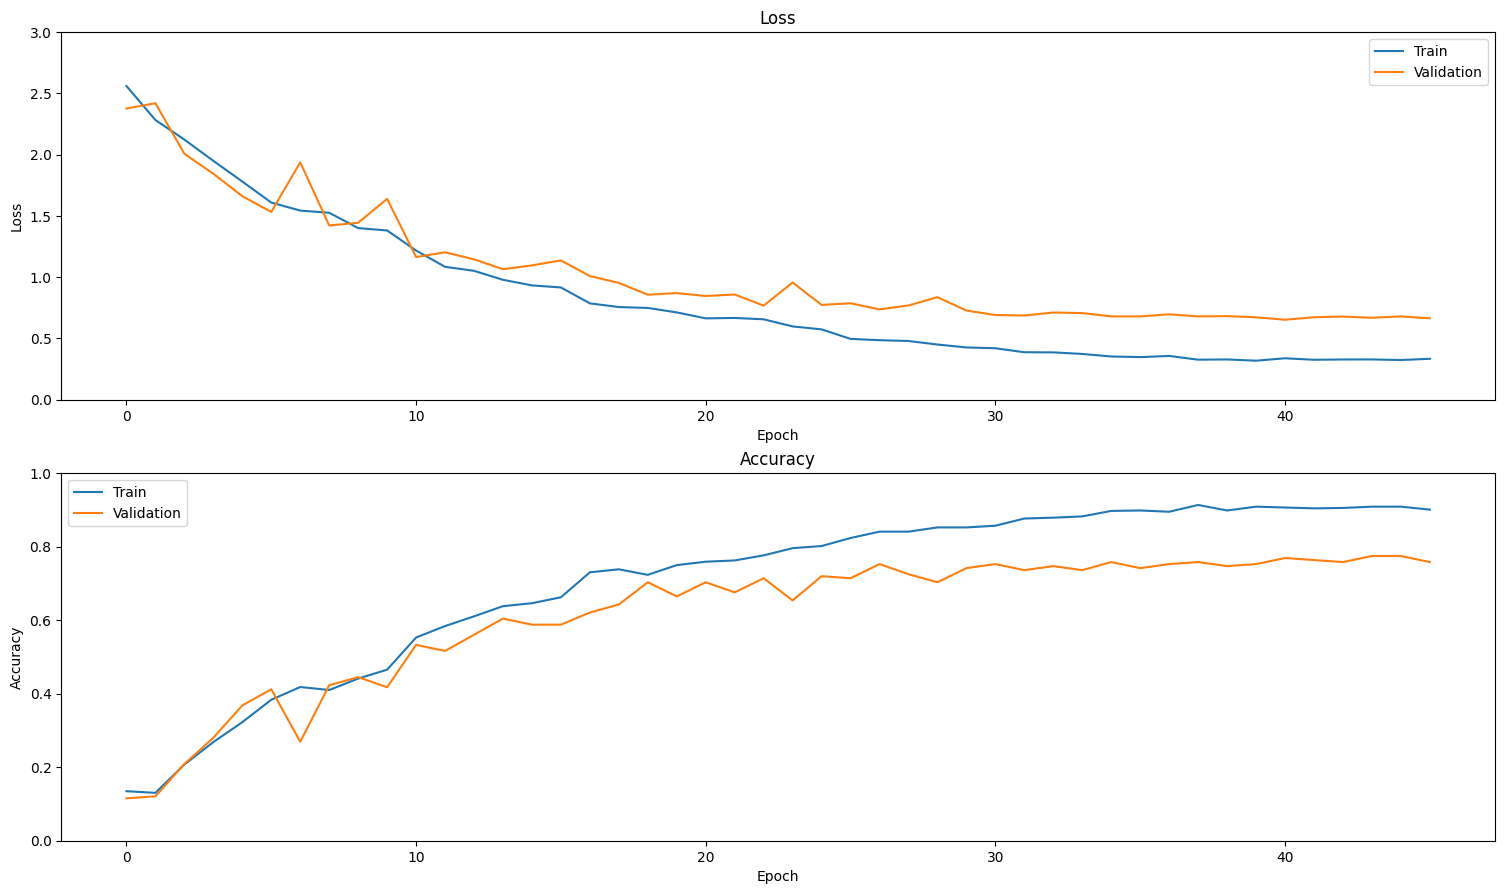

In [14]:
plot_history(history)

In [15]:
model.save('2_plus_1_d.keras')

In [16]:
loss, accuracy = model.evaluate(test_ds)
print(accuracy * 100)

98/98 ━━━━━━━━━━━━━━━━━━━━ 20s 203ms/step - accuracy: 0.7951 - loss: 0.7240
79.08163070678711


434/434 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step


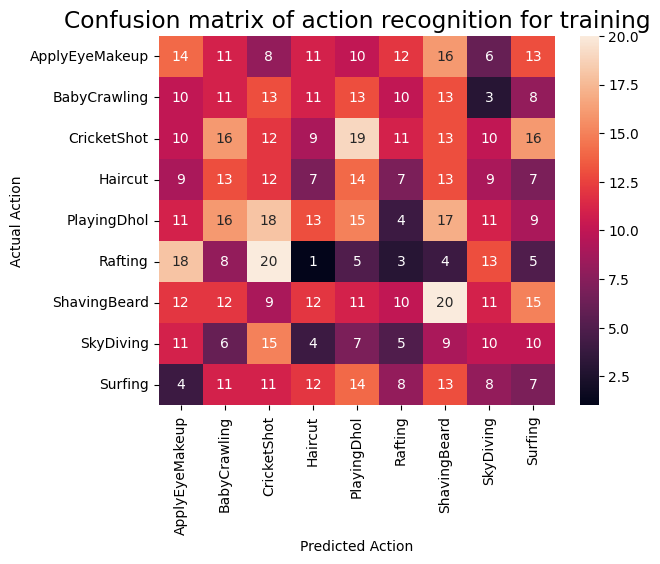

In [17]:
actual, predicted = get_actual_predicted_labels(model, train_ds)
plot_confusion_matrix(actual, predicted, CLASS_LABELS, 'training')

98/98 ━━━━━━━━━━━━━━━━━━━━ 19s 197ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


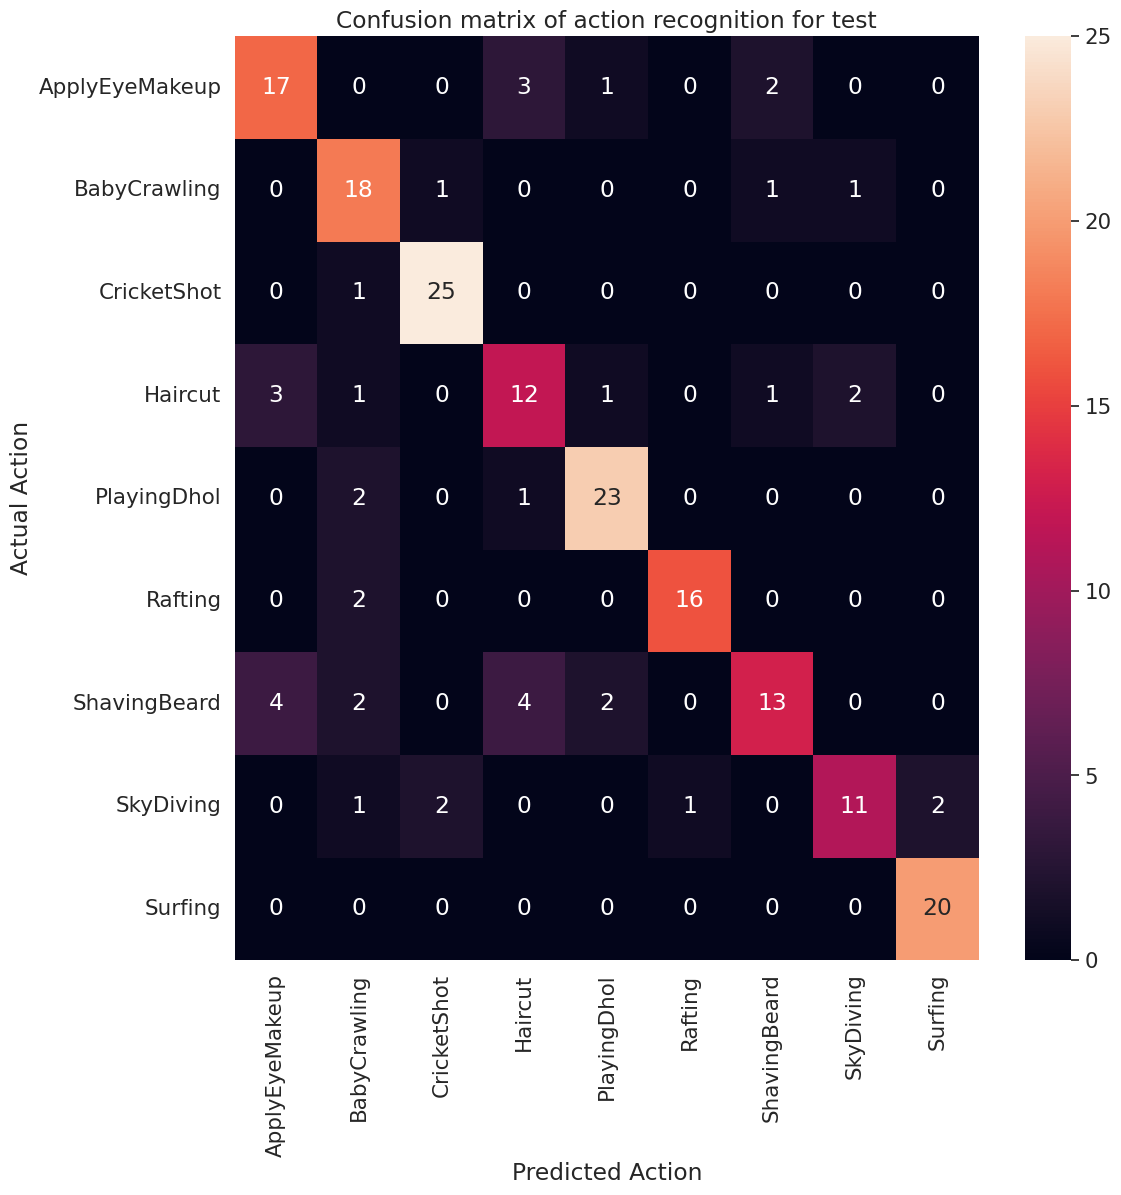

In [18]:
actual, predicted = get_actual_predicted_labels(model, test_ds)
plot_confusion_matrix(actual, predicted, CLASS_LABELS, 'test')